In [1]:
import sirf.STIR as stir
import sirf.Reg as reg
import numpy as np
import os
import sys
# add the source directory to the path
# This is to make everything nice and self-contained
dir_path = os.path.dirname(os.getcwd())
source_path = os.path.join(dir_path, 'source')
sys.path.append(source_path)

# wrappers for STIR and Reg - have a look at these 
# to see what they do.
# I'll do my best to document them,
# but let me know if you have any questions.
from reconstruction.reconstruction import *
from reconstruction.registration import *

# and some additional functions for plotting
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import imageio
from plotting_functions import *
from IPython.display import Image

In [2]:
# First, let's get some template data
data_path = os.path.join(dir_path, 'data', 'template_data')
emission_image = stir.ImageData(os.path.join(data_path, 'emission.hv'))
attenuation_image = stir.ImageData(os.path.join(data_path, 'attenuation.hv'))
template_sinogram = stir.AcquisitionData(os.path.join(data_path, 'template_sinogram.hs'))


INFO: Setting energy window keys as in STIR3.0

INFO: Detected view-mashing factor 4 from the number of views (64) and the number of detectors per ring (512).
Adjusting the azimuthal angle offset accordingly (an extra offset of 1.05469 degrees)












Scanner parameters:= 
Scanner type := userdefined
Number of rings                          := 2
Number of detectors per ring             := 512
Inner ring diameter (cm)                 := 102
Average depth of interaction (cm)        := 0.7
Distance between rings (cm)              := 1.35
Default bin size (cm)                    := 0.3129
View offset (degrees)                    := 0
Maximum number of non-arc-corrected bins := 192
Default number of arc-corrected bins     := 192
Number of blocks per bucket in transaxial direction         := 1
Number of blocks per bucket in axial direction              := 1
Number of crystals per block in axial direction             := 1
Number of crystals per block in transaxial direction        := 8
Number of detector layers                                   := 1
Number of crystals per singles unit in axial direction      := 1
Number of crystals per singles unit in transaxial direction := 8
Scanner geometry (BlocksOnCylindrical/Cylindrical/Gen

## What are these?
- The emission image is a map of activity
- The attenuation image is a map of linear attenuation coefficients
- The sinogram is in what we call projection space and is what the imaging device actually measures. It contains counts per LOR

Let's have a look at the images (the template sinogram is currently empty so we'll look at that later)


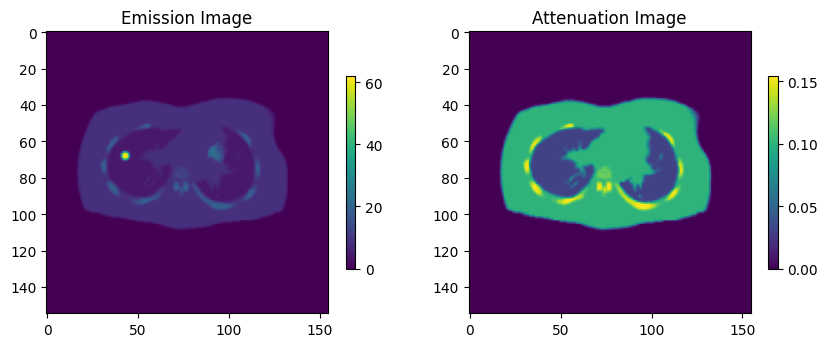

In [3]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
im0 = ax[0].imshow(emission_image.as_array()[0])
ax[0].set_title('Emission Image')
fig.colorbar(im0, ax=ax[0], shrink=0.5)
im1 = ax[1].imshow(attenuation_image.as_array()[0])
ax[1].set_title('Attenuation Image')
fig.colorbar(im1, ax=ax[1], shrink=0.5)

OK, so what is a sinogram?

We're only dealing with 2D images at the moment (what we would term a single slice) so we only need one line of detectors to measure a single slice througha patient.

A PET scanner is comprised of a ring of detectors around a patient. When two of these detectors detect a photon within a specified time window and within a specified energy window (around 511 keV), we record a conincidence and we believe a photon emission has occurred along the line between these two detectors (a line of response). If we plot on an axis all the counts detected on lines of response at a given angle, we get one line of a slice of a sinogram. If we then rotate our view and plot all the counts along these lines of response (LORs), we get the next line of a slice of a sinogram and so on.

In order to demonstrate this more visually, next, we'll generate some simulated sinogram data

In [4]:
acqisition_model_without_attn = get_acquisition_model(emission_image, template_sinogram, attenuation_image.get_uniform_copy(0), num_subsets=1)
simulated_data_without_attn = get_acquired_data(emission_image, acqisition_model_without_attn, noise_factor=0.1)


INFO: Processing view 15 of segment 0

INFO: Processing view 11 of segment 0

INFO: Processing view 4 of segment 0

INFO: Processing view 14 of segment 0

INFO: Processing view 5 of segment 0

INFO: Processing view 7 of segment 0

INFO: Processing view 3 of segment 0

INFO: Processing view 0 of segment 0

INFO: Processing view 1 of segment 0

INFO: Processing view 10 of segment 0

INFO: Processing view 6 of segment 0

INFO: Processing view 2 of segment 0

INFO: Processing view 8 of segment 0

INFO: Processing view 13 of segment 0

INFO: Processing view 12 of segment 0

INFO: Processing view 9 of segment 0

INFO: Processing view 16 of segment 0

INFO: Processing view 17 of segment 0

INFO: Processing view 18 of segment 0

INFO: Processing view 19 of segment 0

INFO: Processing view 20 of segment 0

INFO: Processing view 21 of segment 0

INFO: Processing view 22 of segment 0

INFO: Processing view 23 of segment 0

INFO: Processing view 24 of segment 0

INFO: Processing view 25 of segmen


	attenuation image data are supposed to be in units cm^-1
	Reference: water has mu .096 cm^-1
	Max in attenuation image: 0
	Continuing as you might know what you are doing.





OK. Let's try and demonstrate what we're seeing in a sinogram using a little gif. The line on the right shows the direction of the view and the line on the left shows where the counts from that view are plotted on the sinogram

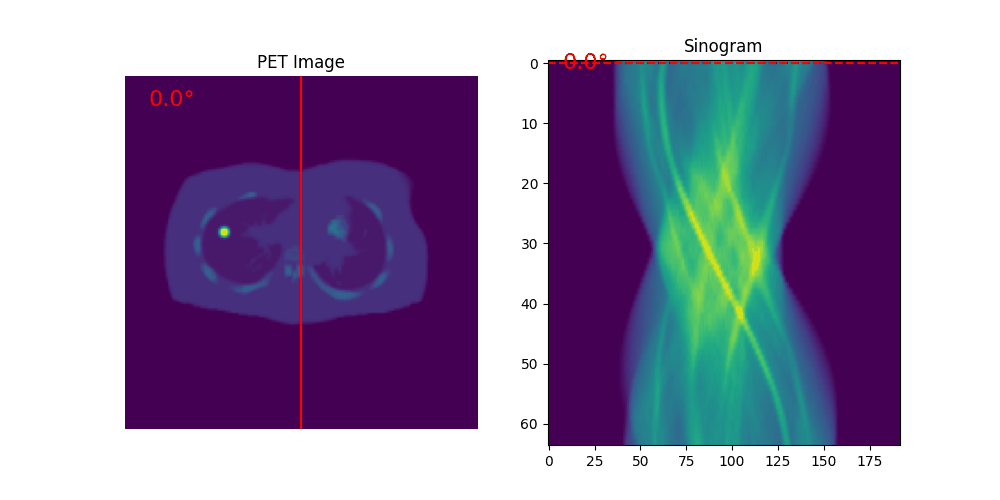

In [5]:
# Angles at which the data is collected
angles = np.linspace(0, 180, simulated_data_without_attn.shape[2], endpoint=False)

# Call the function with your data and desired output filename
plot_pet_acquisition(emission_image.as_array()[0], simulated_data_without_attn.as_array()[0,0], angles, 'pet_acquisition.gif');
# show saved gif
Image(filename='pet_acquisition.gif')

How do we get from an map of activity in image space to a map of detected counts in sinogram space?  We use something called a system matrix, $A = a_{ij}$

$$ a_{ij} u_{j} + \eta_i = f_i $$

where $u_j$ is our image at pixel (or voxel for 3D images) $j$, $f_i$ isn the number of detected counts along LOR $i$ and $\eta_i$ represents additive parts of our model, usually noise. $a_{ij}$ can be thought of as the probability of a photon pair at voxel $j$ being detected by the detector pair $i$.\\

You'll often see this written as something like

$$ A u + \eta = f $$

At the moment, $A$ is just a geometric operator, $G$ (something called a 3D radon transform) that performs a line integral through the image along each LOR.

So $A$ is our aquisition_model, but we haven't yet incorporated attenuation into it. Photon pairs produced by positron annihilation will be scattered (and absorbed to a smaller extent) by tissue. This means that fewer coincidence events will be recorded than our model predicted. In order to account for this, we need to account for attenuation. We do this by adding another (diagonal) operator to account for the change in detector sensitivity for each LOR

$$ N G u + \eta = f $$

A good way to visualise this is by looking at the detector sensitivities in sinogram space. We do this by projecting a uniform image using our system model

In [14]:
acqisition_model_with_attn = stir.AcquisitionModelUsingRayTracingMatrix() # Creating a new geometric model
geometric_transform_for_sensivity = stir.AcquisitionModelUsingRayTracingMatrix() # Creating a new geometric model for modelling the sensitivities
detector_sensitivity_model = stir.AcquisitionSensitivityModel(attenuation_image, geometric_transform_for_sensivity) # We now create N, our attenuation model
acqisition_model_with_attn.set_acquisition_sensitivity(detector_sensitivity_model) # And we add this to our geometric model
acqisition_model_with_attn.set_up(template_sinogram, emission_image) # and finally set up our object, ready for use
detector_sensitivities_without_attn = acqisition_model_without_attn.forward(emission_image.get_uniform_copy(1))
detector_sensitivities_with_attn = acqisition_model_with_attn.forward(emission_image.get_uniform_copy(1))


INFO: Processing view 0 of segment 0

INFO: Processing view 1 of segment 0

INFO: Processing view 4 of segment 0

INFO: Processing view 6 of segment 0

INFO: Processing view 9 of segment 0

INFO: Processing view 10 of segment 0

INFO: Processing view 8 of segment 0

INFO: Processing view 12 of segment 0

INFO: Processing view 13 of segment 0

INFO: Processing view 11 of segment 0

INFO: Processing view 2 of segment 0

INFO: Processing view 14 of segment 0

INFO: Processing view 5 of segment 0

INFO: Processing view 15 of segment 0

INFO: Processing view 3 of segment 0

INFO: Processing view 16 of segment 0

INFO: Processing view 17 of segment 0

INFO: Processing view 18 of segment 0

INFO: Processing view 19 of segment 0

INFO: Processing view 20 of segment 0

INFO: Processing view 21 of segment 0

INFO: Processing view 22 of segment 0

INFO: Processing view 23 of segment 0

INFO: Processing view 24 of segment 0

INFO: Processing view 25 of segment 0

INFO: Processing view 26 of segme

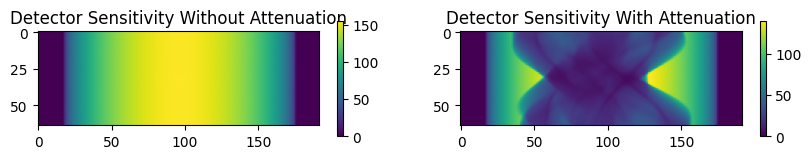

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
im0 = ax[0].imshow(detector_sensitivities_without_attn.as_array()[0,0])
ax[0].set_title('Detector Sensitivity Without Attenuation')
fig.colorbar(im0, ax=ax[0], shrink=0.3)
im1 = ax[1].imshow(detector_sensitivities_with_attn.as_array()[0,0])
ax[1].set_title('Detector Sensitivity With Attenuation')
fig.colorbar(im1, ax=ax[1], shrink=0.3)

Here you can see that at the edges of both imaged, the sensitivity of the detectors is 0. This is outside the field of view (FoV). The sensitivity increases towards the centre if we ignore attenuation because pixels are visible by more LORs. If we include attenuation in our model, we see that the sensitivity of detectors with LORs through the patient are reduced significantly.

Note that this operator can also include other effectes such as the gaps between detectors, detector efficiencies and whether a detector is working or not. These effects aren't included in this notebook.

Hopefully, this is starting to make you think a little bit about how this fits in with our sensitivity image.

Our detector sensitivity above is

$$ d_i = a_{ij} 1_j = n_{ii} g_{ij} 1_j $$

where n_{jj}$ means that the attenuation correction involves a diagonal matrix. This is what we call a *forward* projection of a uniform image

A sensitivity image is the opposite of this. It's a *backward* projection of a uniform sinogram

$$ s_j =a_{ji} 1_i =  g_{ji} n_{ii} 1_i $$

or 

$$ s = A^\top 1 $$

for our 2D image, with and without attenuation, it looks like this

In [17]:
sensitivity_image_without_attn = acqisition_model_without_attn.backward(simulated_data_without_attn.get_uniform_copy(1))
sensitivity_image_with_attn = acqisition_model_with_attn.backward(simulated_data_without_attn.get_uniform_copy(1))

applying unnormalisation...ok
backprojecting...
INFO: Processing view 4 of segment 0

INFO: Processing view 13 of segment 0

INFO: Processing view 14 of segment 0

INFO: Processing view 15 of segment 0

INFO: Processing view 8 of segment 0

INFO: Processing view 5 of segment 0

INFO: Processing view 9 of segment 0

INFO: Processing view 1 of segment 0

INFO: Processing view 0 of segment 0

INFO: Processing view 11 of segment 0

INFO: Processing view 10 of segment 0

INFO: Processing view 12 of segment 0

INFO: Processing view 2 of segment 0

INFO: Processing view 6 of segment 0

INFO: Processing view 7 of segment 0

INFO: Processing view 3 of segment 0

INFO: Processing view 16 of segment 0

INFO: Processing view 17 of segment 0

INFO: Processing view 18 of segment 0

INFO: Processing view 20 of segment 0

INFO: Processing view 21 of segment 0

INFO: Processing view 19 of segment 0

INFO: Processing view 22 of segment 0

INFO: Processing view 23 of segment 0

INFO: Processing view 24 o

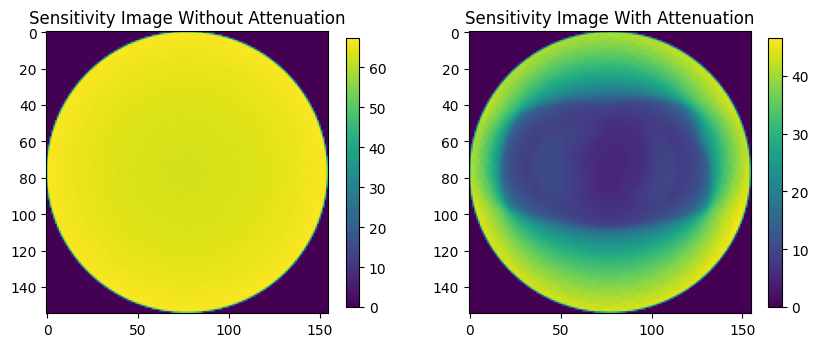

In [19]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
im0 = ax[0].imshow(sensitivity_image_without_attn.as_array()[0])
ax[0].set_title('Sensitivity Image Without Attenuation')
fig.colorbar(im0, ax=ax[0], shrink=0.7)
im1 = ax[1].imshow(sensitivity_image_with_attn.as_array()[0])
ax[1].set_title('Sensitivity Image With Attenuation')
fig.colorbar(im1, ax=ax[1], shrink=0.7)

The sensitivity image pixel values are related to the probabilit of a photon pair emitted at that pixel being detected by the scanner. You can see here, again, that no photon pairs can be detected outside fo the scanner's FoV and that photon pairs produced in and around the patient are less likely to be detected because of attenuation

So, where does the sensitivity image fit into PET imaging?

It can be important to be able to include information about the sensititivity of our system when we are reconstruction an image of the activity within a patient.

One of the most well known algorithms in iterative PET reconstruction (have a little read or ask me about what this means, if you don't understand) is the maximum likelihood expectation maximisation algorithm (MLEM). An update of this equation (moving from an image estimate at iteration $k$ to an updated estimate at iteration $k+1$) is

$$ u^{(k+1)}_j = \frac{u^{(k)}_j}{s_j}a_{ji}\frac{f_i}{a_{ij}u^{(k)}_j + \eta_i} $$

Don't worry too much about what it all means yet - it's a bit complicated - but note that we need to divide by the sensitivity image each time in order to update our image.



I think that I'll leave this here for now. Shortly, I'll complete a notebook describing what might happen to our reconstructed image if we further complicate the picture by introducing patient motion

I'll also soon release a notebook explaining some of the networks and strategies that we used in the previous year's work

Please don't hesitate to ask any questions or we can even go through the notebook together if there's something that you don't understand. My email is sam.porter.18@ucl.ac.uk